In [5]:
# check version number
from __future__ import annotations
import glob
import imblearn
import matplotlib.pyplot as plt
import numpy as np
import time
from abc import ABC, abstractmethod
from typing import List, Tuple

print(imblearn.__version__, np.__version__)

0.12.4 2.1.2


### Loading all relevant data

We will be loading the following csvs into a numpy array
- Training set and its labels
- Validation set and its labels
- Test set

The training and validation sets were generated using SMOTE.
The labels were one hot encoded

In [6]:
X_train = np.loadtxt('training_set.csv', delimiter=',')
y_train = np.loadtxt('training_labels.csv', delimiter=',', dtype=int)
X_validate = np.loadtxt('validation_set.csv', delimiter=',')
y_validate = np.loadtxt('validation_labels.csv', delimiter=',', dtype=int)
X_test = np.loadtxt('AI201_PA3_ANN_Data/test_set.csv', delimiter=',')
y_train_adj = y_train - 1
y_train_adj_encoded = np.eye(8)[y_train_adj]
y_validate_adj = y_validate - 1
y_validate_adj_encoded = np.eye(8)[y_validate_adj]

/tmp/ipykernel_385/3231284274.py:2: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  y_train = np.loadtxt('training_labels.csv', delimiter=',', dtype=int)
/tmp/ipykernel_385/3231284274.py:4: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it

### Class definitions and initial run of our neural network

Here we just define the layers by setting the number of neurons they will have
as well as generating the initial weights. The MultiLayerPerceptron then takes
those layers as attributes where it can train itself from data that we input.

We will also try to run our neural network to observe its initial performance.

For the default values:
- eta = 0.01
- momentum = 0.9
- batch size = 200
- epochs = 100

In [7]:
class ActivationFunctionBaseClass(ABC):
    """ 
    Abstract class for activation functions.
    We instantiate its children and then assign
    it to the layer's attribute which is activation_fn
    """
    
    @abstractmethod
    def activate(self, v):
        """ 
        Applies the activation function to the net internal value
        and returns the layer output
        
        Args:
            v (np.ndarray): net internal value

        Returns:
            np.ndarray: The output of the layer
        """
        pass

    @abstractmethod
    def derive(self, y):
        """
        Method to differentiate the activation function.
        We will use this on the output rather than the
        net internal value since we've already derived
        the three activation fns we're using

        Args:
            y (np.ndarray): output vector
        Returns:
            np.ndarray: Returns the term that's going to be
                multiplied to either the error if it's the
                output layer or the dot product of the
                following layer's local gradient and weights
                if the hidden layer
        """
        pass


class LogisticActivation(ActivationFunctionBaseClass):
    def __init__(self):
        self.a = 2 # The logistic slope param

    def activate(self, v: float) -> float:
        z = self.a * v

        # return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
        return 1 / (1 + np.exp(-z))
    
    def derive(self, v: np.ndarray):
        return self.a * np.multiply(v, (1 - v))


class HyperbolicTangentActivation(ActivationFunctionBaseClass):
    def __init__(self):
        self.a = 1.716 # a tanh parameter
        self.b = 2/3 # b tanh parameter

    def activate(self, v: float) -> float:
        return self.a * np.tanh(self.b * v)
    
    def derive(self, v: float) -> float:
        return (self.b / self.a) * (self.a - v) * (self.a + v)
    

class LeakyReLUActivation(ActivationFunctionBaseClass):
    def __init__(self):
        self.a = 0.01 # leaky relu parameter

    def activate(self, v: np.ndarray) -> np.ndarray:
        return np.where(v > 0, v, v * self.a)

    def derive(self, v: np.ndarray) -> np.ndarray:
        return np.where(v > 0, 1, self.a)


class Layer:
    """
    Representation of layers in a neural network which holds the
    weights and the bias

    Args:
        activation_fn (ActivationFunctionBaseClass): Handles changing of
            the activation function
        num_input (int): Number of inputs coming into the layer
        num_of_neurons (int): How many 'neurons' are inside the layer. Can also
            mean the number of features the output will have as it points to
            the next layer
        bias (np.ndarray): a (num_of_neurons, ) shaped vector that will be
            added to the net internal value of the neuron. Also trainable. 
        weights (np.ndarray): Representation of the weights per neuron of
            the layer. This is a (num_of_neurons, num_input) shaped matrix
    """
    def __init__(
        self, 
        activation_fn: ActivationFunctionBaseClass, 
        weights: np.ndarray,
        bias: np.ndarray,
        num_input: int,
        num_of_neurons: int
    ):
        self.activation_fn = activation_fn
        self.weights = weights
        self.num_input = num_input
        self.num_of_neurons = num_of_neurons
        self.bias = bias

    @classmethod
    def initialize_layer(
        cls, 
        activation_fn: ActivationFunctionBaseClass,
        num_input: int, 
        num_of_neurons: int,
    ):
        """
        Initializes the weights. If the activation assigned is either
        logistic or tanh, it will use the He init or the Kaiming init.
        Else, it will use the Xavier (Golot) init. This also handles
        the initialization of the 
        
        Args:
            activation_fn (ActivationFunctionBaseClass): Handles changing of
            the activation function
            num_input (int): Number of inputs coming into the layer
            num_of_neurons (int): How many 'neurons' are inside the layer. 
                Can also mean the number of features the output will have as it
                points to the next layer

        Returns:
            Layer: an instance of the Layer class with freshly minted weights
        """
        if (
            isinstance(activation_fn, LogisticActivation) 
            or isinstance(activation_fn, HyperbolicTangentActivation)
        ):
            # Initialize with Xavier Glorot
            np.random.seed(42)
            limit = np.sqrt(6 / (num_input + num_of_neurons))
            weights = np.random.uniform(
                -limit, limit, (num_input, num_of_neurons))
        else:
            # Initialize weights with He init
            np.random.seed(42)
            stddev = np.sqrt(2. / num_input)
            weights = np.random.normal(0, stddev, (num_input, num_of_neurons))
            
        bias = np.zeros((num_of_neurons,))
        return cls(activation_fn, weights, bias, num_input, num_of_neurons)
    
    @property
    def shape(self):
        return self.weights.shape
    
    def activate(self, v):
        """
        Takes in the net internal value vector and then returns output

        Args:
            v (np.ndarray): the net internal value vector

        Returns:
            np.ndarray: the output vector
        """
        return self.activation_fn.activate(v)
    
    def derive(self, y):
        """
        Takes in the output vector of the layer and returns the differentiated
        activation function

        Args:
            v (np.ndarray): output vector of the layer

        Returns:
            np.ndarray: derivative of the activation function
        """
        return self.activation_fn.derive(y)
    
    def reset(self, num_input = None, num_of_neurons = None):
        """
        Reinitializes the layer's weights and biases. Useful for hyperparameter
        tuning and the likes.
        """
        if not num_input:
            num_input = self.num_input

        if not num_of_neurons:
            num_of_neurons = self.num_of_neurons

        new_instance = Layer.initialize_layer(
            self.activation_fn, num_input, num_of_neurons
        )
        self.weights = new_instance.weights
        self.bias = new_instance.bias

    def save_weights_and_bias(self, csv_name: str):
        """
        Saves the weights and bias in a csv file. The bias will always be the
        first row

        Args:
            csv_name (str): Name of the file to be created
        """
        arr_to_save = np.append([self.bias], self.weights, axis=0)
        np.savetxt(csv_name, arr_to_save, delimiter=',')

    @classmethod
    def load_weights_and_bias(
        cls, 
        filepath: str, 
        activation_fn: ActivationFunctionBaseClass
    ) -> Layer:
        """
        Loads the weights and bias values of a layer from a given file path

        Args:
            filepath (str): filepath to the csv file
            activation_fn (ActivationFunctionBaseClass): The activation func
                to use in the layer

        Returns:
            Layer: The layer with the pre-trained weights and bias
        """
        weights_and_bias = np.loadtxt(filepath, delimiter=',')
        bias = weights_and_bias[0]
        weights = weights_and_bias[1:]
        return cls(
            activation_fn, 
            weights, 
            bias,
            weights.shape[0], 
            weights.shape[1]
        )


class MultiLayerPerceptron:
    """ 
    Basically the class that would instantiate our networks.
    It holds all the weights of the layers together by having the layers
    be attributes. Also in charge of training the data.

    Args:
        eta (float): The learning rate
        momentum (float): Momentum constant to use in generalized delta rule
        layer1 (Layer): First hidden layer
        layer2 (Layer): Second hidden layer
        layer3 (Layer): Output layer
        training_time (float): Time elapsed for training the neural network
        output_size (int): Number of neurons in the output layer
        conf_matrix (np.ndarray): Confusion matrix to be generated
            after training
    """
    def __init__(self, layers: List[Layer]):
        self.eta = 0.01
        self.momentum = 0.9
        self.layer1 = layers[0]
        self.layer2 = layers[1]
        self.layer3 = layers[2]
        self.training_time = 0
        self.output_size = layers[2].shape[1]
        self.conf_matrix = np.zeros(
            (self.output_size, self.output_size), 
            dtype=int
        )

    def save_weights_and_bias(self, id: str):
        self.layer1.save_weights_and_bias(f'{id}_trained_weights_hl1.csv')
        self.layer2.save_weights_and_bias(f'{id}_trained_weights_hl2.csv')
        self.layer3.save_weights_and_bias(f'{id}_trained_weights_ol.csv')

    @classmethod
    def load_weights_and_bias(cls, id: str):
        file_list = glob.glob(f'{id}_trained_weights_*.csv')
        layers = []
        for i, file in enumerate(file_list):
            if i == len(file_list) - 1:
                layer = Layer.load_weights_and_bias(file, LogisticActivation())
            else:
                af = file.split('_')[0]
                activation_fn = (
                    HyperbolicTangentActivation() 
                    if af == 'tanh' 
                    else LeakyReLUActivation()
                )
                layer = Layer.load_weights_and_bias(file, activation_fn)
            layers.append(layer)

        return cls(layers)

    def reset_layers(self):
        """ Reinitializes all the attached layers' weights and biases """
        self.layer1.reset()
        self.layer2.reset()
        self.layer3.reset()

    def generate_metrics(self):
        """
        Returns the different values we can use to evaluate performance.
        Data here is only available after training

        Returns:
            tuple: performance metrics (
                true positives,
                false positives,
                false negatives,
                accuracy,
                precision,
                recall,
                f1 score,
                Matthews correlation coefficient
            )
        """
        tp = np.diag(self.conf_matrix)
        fp = self.conf_matrix.sum(axis=0) - tp
        fn = self.conf_matrix.sum(axis=1) - tp
        tn = self.conf_matrix.sum() - (fn + fp + tp)
        accuracy = (tp + tn) / (tp + fp + tn + fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * (precision * recall) / (precision + recall)
        mcc = np.divide(
            (tp * tn) - (fp * fn),
            np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
        )

        return tp, fp, fn, tn, accuracy, precision, recall, f1, mcc

    def forward_pass(self, X) -> Tuple[np.ndarray]:
        """ 
        Returns the net internal values (v) as well 
        as the outputs (y) of the 3 layers.

        Args:
            X (np.ndarray): The input to the network
        
        Returns:
            tuple: (
                Net internal value of first hidden layer
                Output of first hidden layer
                Net internal value of second hidden layer
                Output of second hidden layer
                Net internal value of output layer
                Output of the output layer
            )
        """
        vi = np.dot(X, self.layer1.weights) + self.layer1.bias
        yi = self.layer1.activate(vi)

        vj = np.dot(yi, self.layer2.weights) + self.layer2.bias
        yj = self.layer2.activate(vj)

        vk = np.dot(yj, self.layer3.weights) + self.layer3.bias
        yk = self.layer3.activate(vk)

        return vi, yi, vj, yj, vk, yk
    
    def generate_batches(self, X, y, batch_size):
        """ 
        Divide the training data in batches 
        
        Args:
            X (np.ndarray): The set to be batched
            y (np.ndarray): Labels to be batched
            batch_size (int): How many items per batch

        Returns:
            generator: Tuple[batched X, batched y]
        """
        for i in range(0, len(X), batch_size):
            yield X[i:i + batch_size], y[i:i + batch_size]

    def predict(self, X):
        """ 
        Returns a vector that represents the different labels 
        predicted per row of input

        Args:
            X (np.ndarray): The set to be predicted

        Returns:
            np.ndarray: An array of its predicted class (1 - 8)
        """
        *_, output = self.forward_pass(X)
        return np.argmax(output, axis=1) + 1
    
    def generate_confusion_matrix(self, title='Confusion Matrix'):
        """
        Generates the plot of the confusion matrix

        Args:
            title (str): What the plot's title will be
        """
        size = self.layer3.num_of_neurons
        plt.figure(figsize=(8, 6))
        plt.imshow(self.conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title)
        plt.colorbar()

        # Labeling the axes, ensuring they start from 0 to 7
        tick_marks = np.arange(size)
        plt.xticks(tick_marks, tick_marks + 1)  # Class labels for x-axis
        plt.yticks(tick_marks, tick_marks + 1)  # Class labels for y-axis

        # Adding text labels to each cell in the matrix
        thresh = self.conf_matrix.max() / 2.
        for i in range(size):
            for j in range(size):
                plt.text(j, i, self.conf_matrix[i, j],
                    ha="center", va="center",
                    color="white" if self.conf_matrix[i, j] > thresh else "black")

        # Setting the axis labels
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.grid(
            True, 
            which='both', 
            axis='both', 
            color='gray', 
            linestyle='--', 
            linewidth=0.5
        )
        plt.show()
    
    def train(
        self, 
        X_train, 
        y_train, 
        X_validate, 
        y_validate, 
        epochs=100, 
        batch_size=200
    ):
        """ 
        Goes through forward pass and backprop per epoch to update
        to update the weights

        Args:
            X_train (np.ndarray): The training set
            y_train (np.ndarray): The training labels (one hot encoded)
            X_validate (np.ndarray): The validation set
            y_validate (np.ndarray): The validation labels (one hot encoded)
            epochs (int): Number of iterations we want the model to be trained
            batch_size (int): How many samples per minibatch that we'll train
                the weights on in a vectorized fashion
        
        Returns:
            tuple: (
                training_errors_per_epoch,
                validation_errors_per_epoch,
                misclassifications_per_epoch
            )
        """
        self.conf_matrix = np.zeros(
            (self.output_size, self.output_size), 
            dtype=int
        )
        start_time = time.time()
        validation_errors_per_epoch = np.array([])
        training_errors_per_epoch = np.array([])
        misclassifications_per_epoch = np.array([])

        for epoch in range(epochs + 1):
            batches = self.generate_batches(X_train, y_train, batch_size)
            epoch_sse = 0
            for batch in batches:
                X_batch, y_batch = batch
                v1, y1, v2, y2, v3, y3 = self.forward_pass(X_batch)

                # backpropagation
                error = y_batch - y3
                delta_out = error * self.layer2.derive(y3)
                Delta_out = np.matmul(y2.T, delta_out)
                bd3 = delta_out

                delta_h2 = np.multiply(
                    self.layer2.derive(y2), 
                    np.dot(delta_out, self.layer3.weights.T)
                )
                Delta_w_h2 = np.matmul(y1.T, delta_h2)
                bd2 = delta_h2
                
                delta_h1 = np.multiply(
                    self.layer1.derive(y1),
                    np.dot(delta_h2, self.layer2.weights.T)
                )
                Delta_w_h1 = np.matmul(X_batch.T, delta_h1)
                bd1 = delta_h1
                mean_error = np.mean(error, axis=0)
                sse = 0.5 * np.dot(mean_error, mean_error)

                epoch_sse += sse # aggregate all batch_sses
                # update the weights for the next iteration
                self.layer1.weights += (
                    self.eta * (1/batch_size) * Delta_w_h1)
                self.layer1.bias += (
                    self.eta * (1/batch_size) * np.mean(bd1, axis=0))
                self.layer2.weights += (
                    self.eta * (1/batch_size) * Delta_w_h2)
                self.layer2.bias += (
                    self.eta * (1/batch_size) * np.mean(bd2, axis=0))
                self.layer3.weights += (
                    self.eta * (1/batch_size) * Delta_out)
                self.layer3.bias += (
                    self.eta * (1/batch_size) * np.mean(bd3, axis=0))
        
            # The time based eta scheduler... this will lower the eta as the
            # iterations go by so we won't keep overshooting the global minimum
            epoch_sse /= epochs # average by the epochs
            print(f'Epoch {epoch} SSE: {epoch_sse}')
            training_errors_per_epoch = np.append(
                training_errors_per_epoch, epoch_sse)
            
            # Per 5 epochs, we check for misclassifications.
            if epoch % 5 == 0:
                *_, output = self.forward_pass(X_validate)
                error = y_validate - output
                mean_error = np.mean(error, axis=0) # average the validation error
                validation_sse = 0.5 * np.dot(mean_error, mean_error)
                predictions = np.argmax(output, axis=1) + 1
                desired = np.argmax(y_validate, axis=1) + 1
                misclassifications = np.sum(predictions != desired)
                print(f"""Validation SSE: {validation_sse}; Misclassifications: {misclassifications}""")
                validation_errors_per_epoch = np.append(
                    validation_errors_per_epoch, validation_sse)
                misclassifications_per_epoch = np.append(
                    misclassifications_per_epoch, misclassifications)

                # If it's the final epoch, we fill up our confusion matrix
                if epoch == epochs:
                    for d, p in zip(predictions, desired):
                        self.conf_matrix[d - 1, p - 1] += 1

        end_time = time.time()
        self.training_time = end_time - start_time # record training time
        return (
            training_errors_per_epoch, 
            validation_errors_per_epoch, 
            misclassifications_per_epoch,
        )

layer1 = Layer.initialize_layer(HyperbolicTangentActivation(), 354, 8)
layer2 = Layer.initialize_layer(HyperbolicTangentActivation(), 8, 8)
layer3 = Layer.initialize_layer(LogisticActivation(), 8, 8)
network_a = MultiLayerPerceptron([layer1, layer2, layer3])
network_a.eta = 0.1
(
    training_errors_per_epoch, 
    validation_errors_per_epoch, 
    misclassifications_per_epoch,
) = network_a.train(
    X_train, y_train_adj_encoded, X_validate, y_validate_adj_encoded, epochs=100, batch_size=64)

Epoch 0 SSE: 0.029078031641590812
Validation SSE: 0.002470438389383275; Misclassifications: 305
Epoch 1 SSE: 0.021981245894517238
Epoch 2 SSE: 0.02566124920844191
Epoch 3 SSE: 0.024346477253712015
Epoch 4 SSE: 0.022415229799627467
Epoch 5 SSE: 0.021090288709776934
Validation SSE: 0.0023937893692437344; Misclassifications: 147
Epoch 6 SSE: 0.019865546437413836
Epoch 7 SSE: 0.01822765040160021
Epoch 8 SSE: 0.01636393789639724
Epoch 9 SSE: 0.014509006290912363
Epoch 10 SSE: 0.014123049629632232
Validation SSE: 0.0017205230414473161; Misclassifications: 88
Epoch 11 SSE: 0.014651415172101223
Epoch 12 SSE: 0.013755468464270788
Epoch 13 SSE: 0.012684264604713818
Epoch 14 SSE: 0.011710302506991701
Epoch 15 SSE: 0.010851696631284775
Validation SSE: 0.0017377074165458475; Misclassifications: 67
Epoch 16 SSE: 0.010093084460844661
Epoch 17 SSE: 0.009421399154845201
Epoch 18 SSE: 0.00884437108251309
Epoch 19 SSE: 0.008357866048341647
Epoch 20 SSE: 0.007891254764002471
Validation SSE: 0.001645219011

### Testing out different neurons for the hidden layers

For the number of neurons, we'll just be testing powers of 2, with the added condition that the first hidden layer is twice the size of the second hidden layer.

Will be choosing the configuration with the least validation error


In [8]:
heaton = (244, 122)
power_of_two = (64, 32)
power_of_two_again = (128, 64)
power_of_two_thrice = (256, 128)
hagan = (16, 8)
items = [(16, 8), (32, 16), (64, 32), (128, 64), (256, 128)]
output_dict = {}
for item in items:
    first, second = item
    network_a.layer1.reset(354, first)
    network_a.layer2.reset(first, second)
    network_a.layer3.reset(second, 8)
    tepe, vepe, mpe = network_a.train(
        X_train, 
        y_train_adj_encoded, 
        X_validate, y_validate_adj_encoded)

    # Get the last validation error as well as the training time
    output_dict[item] = {
        'validation_error': vepe[-1],
        'training_time': network_a.training_time
    }

output_dict

Epoch 0 SSE: 0.01233594398093346
Validation SSE: 0.0011093038725136606; Misclassifications: 394
Epoch 1 SSE: 0.0021320857611549717
Epoch 2 SSE: 0.0032970656044093655
Epoch 3 SSE: 0.0036852358934515443
Epoch 4 SSE: 0.004415783618515708
Epoch 5 SSE: 0.00564685180128601
Validation SSE: 0.009528798283362765; Misclassifications: 236
Epoch 6 SSE: 0.006453868808991439
Epoch 7 SSE: 0.004699853152873811
Epoch 8 SSE: 0.0060881876615435345
Epoch 9 SSE: 0.0051240803082074
Epoch 10 SSE: 0.005795651503899285
Validation SSE: 0.014198596543930488; Misclassifications: 242
Epoch 11 SSE: 0.005462236782677214
Epoch 12 SSE: 0.005122716167819024
Epoch 13 SSE: 0.0051981347085660904
Epoch 14 SSE: 0.00461316148873192
Epoch 15 SSE: 0.004130671749475661
Validation SSE: 0.0052417334553945955; Misclassifications: 139
Epoch 16 SSE: 0.004682993231821508
Epoch 17 SSE: 0.004329324208688656
Epoch 18 SSE: 0.004155017849701172
Epoch 19 SSE: 0.0039008786922414794
Epoch 20 SSE: 0.0040333575547812014
Validation SSE: 0.00161

{(16, 8): {'validation_error': np.float64(0.00016198743779462414),
  'training_time': 3.289741039276123},
 (32, 16): {'validation_error': np.float64(5.977770911787925e-05),
  'training_time': 5.180688381195068},
 (64, 32): {'validation_error': np.float64(4.381402780857322e-05),
  'training_time': 11.624378204345703},
 (128, 64): {'validation_error': np.float64(6.229053495413527e-05),
  'training_time': 22.582300186157227},
 (256, 128): {'validation_error': np.float64(6.552091902871145e-05),
  'training_time': 36.04626989364624}}

### Choosing eta for 64 x 32
So the best in terms of validation error is if we have 64 in the first hidden layer and then 32 in the second hidden layer. We then try to optimize eta. We don't want an eta too high in the case that it might diverge and we just wasted our time. We can just compensate with adding more epochs

The etas we'll be testing are:
- 0.01
- 0.025
- 0.05
- 0.075
- 0.1

In [9]:
etas = [
    0.01,
    0.025,
    0.05,
    0.075,
    0.1
]
etas_output_dict = {}

for eta in etas:
    network_a.layer1.reset(354, 64)
    network_a.layer2.reset(64, 32)
    network_a.layer3.reset(32, 8)
    network_a.eta = eta
    print(f'Processing eta = {eta}')
    tepe, vepe, mpe = network_a.train(
        X_train, y_train_adj_encoded, X_validate, y_validate_adj_encoded, batch_size=64)

    # Get the last validation error
    etas_output_dict[eta] = {
        'validation_error': vepe[-1],
        'training_time': network_a.training_time
    }

etas_output_dict

Processing eta = 0.01
Epoch 0 SSE: 0.040398408485328566
Validation SSE: 0.0012656974095190167; Misclassifications: 421
Epoch 1 SSE: 0.012652477630368988
Epoch 2 SSE: 0.011710580347158195
Epoch 3 SSE: 0.010839679131665643
Epoch 4 SSE: 0.01010384234089432
Epoch 5 SSE: 0.009496050229135246
Validation SSE: 0.0005283814998561816; Misclassifications: 208
Epoch 6 SSE: 0.00898387367834403
Epoch 7 SSE: 0.008543141447957687
Epoch 8 SSE: 0.008156986250735786
Epoch 9 SSE: 0.0078121498447164366
Epoch 10 SSE: 0.007498619918737896
Validation SSE: 0.00038798791231805835; Misclassifications: 147
Epoch 11 SSE: 0.007209723688203781
Epoch 12 SSE: 0.006941395157762554
Epoch 13 SSE: 0.006691009761208677
Epoch 14 SSE: 0.006456465223229543
Epoch 15 SSE: 0.006235792811208887
Validation SSE: 0.0002539674169103264; Misclassifications: 108
Epoch 16 SSE: 0.0060271544142519486
Epoch 17 SSE: 0.005828954816544172
Epoch 18 SSE: 0.005639904764442003
Epoch 19 SSE: 0.005459001826833533
Epoch 20 SSE: 0.005285465748061769


{0.01: {'validation_error': np.float64(8.452958857854889e-05),
  'training_time': 10.0602126121521},
 0.025: {'validation_error': np.float64(5.6969958984549787e-05),
  'training_time': 9.909377813339233},
 0.05: {'validation_error': np.float64(0.00012670945337150806),
  'training_time': 9.833814859390259},
 0.075: {'validation_error': np.float64(0.0001441790894263184),
  'training_time': 9.942279815673828},
 0.1: {'validation_error': np.float64(0.00013990090181107448),
  'training_time': 10.008012294769287}}

### Tuning the number of epochs
As can be seen above, validation error is the lowest at around $\eta = 0.025$.

We will now be using that eta to and keep training our data up to 1000 epochs
just to really minimize our cost function

In [10]:
network_a.eta = 0.025
network_a.layer1.reset(354, 64)
network_a.layer2.reset(64, 32)
network_a.layer3.reset(32, 8)
tepe_a, vepe_a, mpe_a = network_a.train(
    X_train, 
    y_train_adj_encoded, 
    X_validate, 
    y_validate_adj_encoded, 
    epochs=1000,
    batch_size=64
)

Epoch 0 SSE: 0.0026148603259550382
Validation SSE: 0.000905822548967476; Misclassifications: 291
Epoch 1 SSE: 0.0011338178739753533
Epoch 2 SSE: 0.000984564703897726
Epoch 3 SSE: 0.0008844310081644618
Epoch 4 SSE: 0.000810527052439783
Epoch 5 SSE: 0.0007531394521684294
Validation SSE: 0.000959190025108219; Misclassifications: 115
Epoch 6 SSE: 0.0007077052133695254
Epoch 7 SSE: 0.0006713801125691886
Epoch 8 SSE: 0.0006421853718704953
Epoch 9 SSE: 0.0006184237948189284
Epoch 10 SSE: 0.0005991091432673418
Validation SSE: 0.000901445457747485; Misclassifications: 73
Epoch 11 SSE: 0.0005845558209724944
Epoch 12 SSE: 0.0005755548322075007
Epoch 13 SSE: 0.0005721830085051516
Epoch 14 SSE: 0.0005736178706114393
Epoch 15 SSE: 0.0005784355388669566
Validation SSE: 0.0005763331656836117; Misclassifications: 45
Epoch 16 SSE: 0.0005848125268079647
Epoch 17 SSE: 0.0005907958080304437
Epoch 18 SSE: 0.0005947241981504899
Epoch 19 SSE: 0.0005955545617747931
Epoch 20 SSE: 0.0005929166465937507
Validatio

### Training Network B
A brief summary of our chosen parameters so far:

| Parameter   | Value       |
|-------------|-------------|
| Neurons in HL 1| 64|
| Neurons in HL 2| 32|
| Learning rate | 0.025 |
| Epochs | 1000 |


We then train a new neural network, this time a relu-relu-logistic one, with
the same parameters as Network A. We'll call this Network B.

In [11]:
layer1b = Layer.initialize_layer(LeakyReLUActivation(), 354, 64)
layer2b = Layer.initialize_layer(LeakyReLUActivation(), 64, 32)
layer3b = Layer.initialize_layer(LogisticActivation(), 32, 8)
network_b = MultiLayerPerceptron([layer1b, layer2b, layer3b])
network_b.eta = 0.025
tepe_b, vepe_b, mpe_b = network_b.train(
    X_train, 
    y_train_adj_encoded, 
    X_validate, 
    y_validate_adj_encoded, 
    epochs=1000,
    batch_size=64
)

Epoch 0 SSE: 0.005468352520721623
Validation SSE: 0.0013259257763457272; Misclassifications: 466
Epoch 1 SSE: 0.0012737284094838778
Epoch 2 SSE: 0.0011526310262224332
Epoch 3 SSE: 0.0010368369374151069
Epoch 4 SSE: 0.0009459142284722384
Epoch 5 SSE: 0.0008707762660767321
Validation SSE: 0.000522396309084364; Misclassifications: 175
Epoch 6 SSE: 0.0008061061719660913
Epoch 7 SSE: 0.0007532713029482679
Epoch 8 SSE: 0.0007084930396753963
Epoch 9 SSE: 0.0006713798765678587
Epoch 10 SSE: 0.0006374374029767048
Validation SSE: 0.000566392621650392; Misclassifications: 128
Epoch 11 SSE: 0.0006056765264550801
Epoch 12 SSE: 0.0005763106330280286
Epoch 13 SSE: 0.0005490042866973323
Epoch 14 SSE: 0.000523810738871383
Epoch 15 SSE: 0.0004998222910682069
Validation SSE: 0.000500794166040277; Misclassifications: 78
Epoch 16 SSE: 0.0004769414278057948
Epoch 17 SSE: 0.00045543810645472146
Epoch 18 SSE: 0.00043512566833240224
Epoch 19 SSE: 0.0004177367087312912
Epoch 20 SSE: 0.00040147001731071516
Valid

### Network A vs Network B Plots
The following will be plots of:
- Cost function comparison
- Validation Error comparison
- Misclassifications comparison

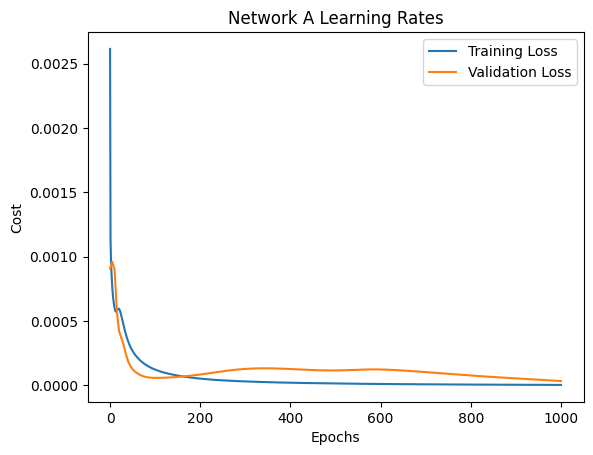

In [12]:
epochs = np.arange(0, 1001)
skip_five = np.arange(0, 1001, 5)
plt.plot(epochs, tepe_a, label="Training Loss")
plt.plot(skip_five, vepe_a, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Network A Learning Rates")
plt.legend()
plt.show()

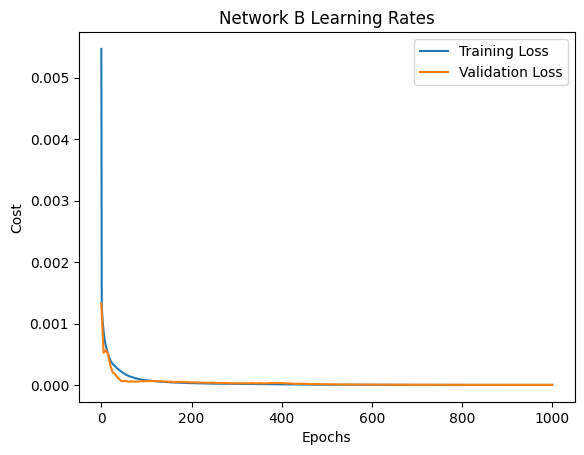

In [13]:
epochs = np.arange(0, 1001)
skip_five = np.arange(0, 1001, 5)
plt.plot(epochs, tepe_b, label="Training Loss")
plt.plot(skip_five, vepe_b, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Network B Learning Rates")
plt.legend()
plt.show()

### Performance Metrics
First shown will be the confusion metrics.

And then we'll calculate the performance metrics so that it will be the average
over all classes (e.g. the final accuracy will be the average of accuracy of prediction class 1, class 2, etc.). The ff performance metrics will be computed:
- Accuracy
- Precision
- Recall
- F1-score
- Matthews Correlation Coefficient (MCC)

This will be further illustrated by a bar graph.

##### For Network A

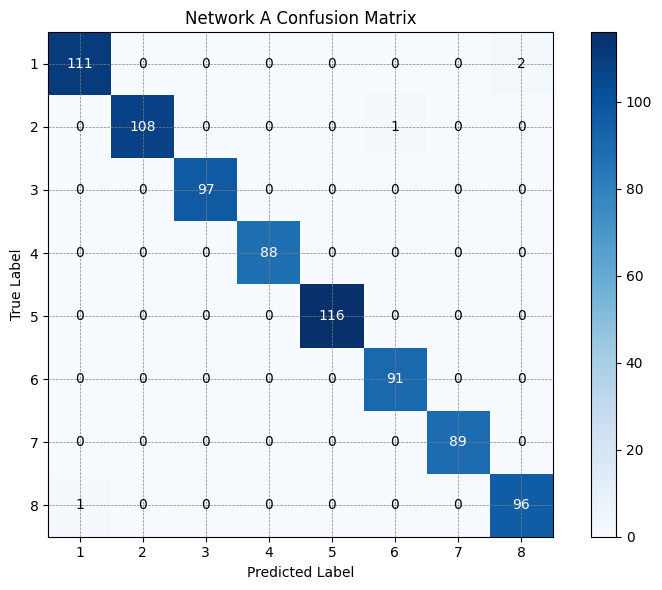

In [14]:
network_a.generate_confusion_matrix(title='Network A Confusion Matrix')

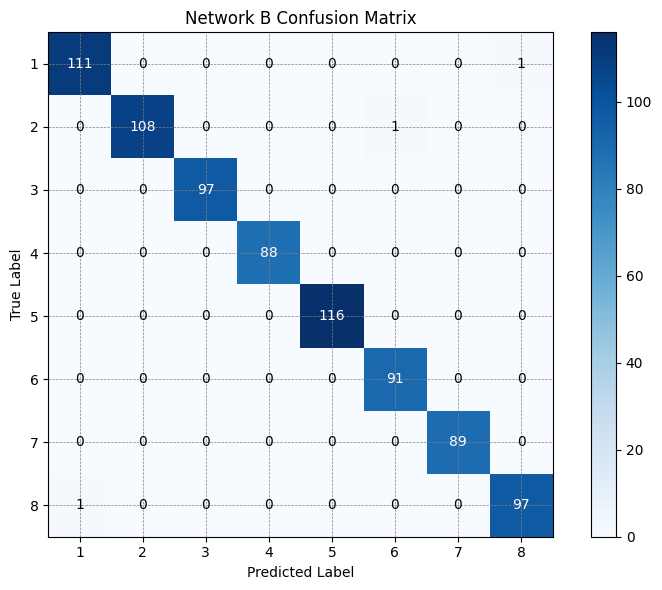

In [15]:
network_b.generate_confusion_matrix(title='Network B Confusion Matrix')

Network a: [0.99875    0.99497421 0.99535216 0.99515116 0.99444082]
Network b: [0.9990625  0.99624972 0.99646163 0.99634932 0.99581511]


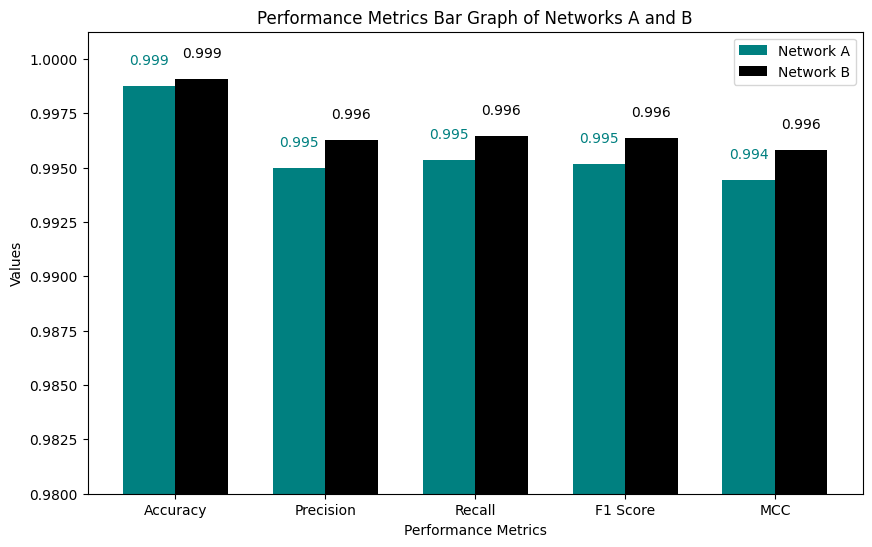

In [16]:
# Average the performance metrics over all classes

*_, a_a, p_a, r_a, f_a, m_a = network_a.generate_metrics()
accuracy_a = a_a.mean(axis=0)
precision_a = p_a.mean(axis=0)
recall_a = r_a.mean(axis=0)
f1_score_a = f_a.mean(axis=0)
mcc_a = m_a.mean(axis=0)

*_, a_b, p_b, r_b, f_b, m_b = network_b.generate_metrics()
accuracy_b = a_b.mean(axis=0)
precision_b = p_b.mean(axis=0)
recall_b = r_b.mean(axis=0)
f1_score_b = f_b.mean(axis=0)
mcc_b = m_b.mean(axis=0)

network_a_metrics = np.array([accuracy_a, precision_a, recall_a, f1_score_a, mcc_a])
network_b_metrics = np.array([accuracy_b, precision_b, recall_b, f1_score_b, mcc_b])
print(f'Network a: {network_a_metrics}')
print(f'Network b: {network_b_metrics}')

# Example data for illustration
categories = np.array(['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC'])

# Parameters for plotting
bar_width = 0.35  # Width of each bar
x = np.arange(len(categories))  # X positions for the bars

# Plotting the bars
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, network_a_metrics, width=bar_width, color='teal', label='Network A')
plt.bar(x + bar_width/2, network_b_metrics, width=bar_width, color='black', label='Network B')

# Adding labels, title, and legend
plt.xlabel('Performance Metrics')
plt.ylabel('Values')
plt.ylim(0.98, 1.00125)  # Expanded y-axis limit for better visibility
plt.title('Performance Metrics Bar Graph of Networks A and B')
plt.xticks(x, categories)  # Set x-ticks to category names
plt.legend()

# Adding value labels above each bar with smaller offsets
for i in range(len(categories)):
    plt.text(x[i] - bar_width/2, network_a_metrics[i] + 0.001, f'{network_a_metrics[i]:.3f}', ha='center', color='teal')
    plt.text(x[i] + bar_width/2, network_b_metrics[i] + 0.001, f'{network_b_metrics[i]:.3f}', ha='center', color='black')

plt.show()

In [17]:
# Save for production!
network_a.save_weights_and_bias('tanh')
network_b.save_weights_and_bias('leaky_relu')

### For production
We'll be saving the weights and biases of both networks in csv format. Suppose we're already in production and want to load our previously trained weights.



In [18]:
tanh_network = MultiLayerPerceptron.load_weights_and_bias('tanh')
leaky_relu_network = MultiLayerPerceptron.load_weights_and_bias('leaky_relu')

tanh_prediction = tanh_network.predict(X_test)
np.savetxt('predictions_for_test_tanh.csv', tanh_prediction)
leaky_relu_prediction = leaky_relu_network.predict(X_test)
np.savetxt('predictions_for_test_leakyrelu.csv', leaky_relu_prediction)